https://github.com/XuJiacong/PIDNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installs

In [ ]:
!pip install pytorch_lightning
!pip install transformers

# Imports

In [ ]:
import datetime

import collections as cl

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

from PIL import Image, ImageShow, ImageDraw
from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Function, Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
from torchvision import transforms, utils
import torchvision.models as models

from typing import Optional

import json

import os
import numpy as np
import pandas as pd
import random, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Downloading and resizing photos

In [ ]:
!mkdir mas_data

!cp -r drive/MyDrive/'Дипломный проект'/datasets/mas-roofs/ mas_data

In [ ]:
!rm -r mas_data/mas-roofs/*/.ipynb_checkpoints

rm: cannot remove 'mas_data/mas-roofs/*/.ipynb_checkpoints': No such file or directory


In [ ]:
!mkdir data

!cp -r drive/MyDrive/'Дипломный проект'/datasets/my_dataset/* data 

In [ ]:
from PIL import Image

for image, mask in zip(os.listdir('data/test'), os.listdir('data/test_labels')):
    img = Image.open(os.path.join('data/test', image)).resize((1500, 1500), Image.ANTIALIAS)
    mask = Image.open(os.path.join('data/test_labels', mask)).resize((1500, 1500), Image.ANTIALIAS)

    img.save(os.path.join('data/test', image))
    mask.save(os.path.join('data/test_labels', image))

for image, mask in zip(os.listdir('data/val'), os.listdir('data/val_labels')):
    img = Image.open(os.path.join('data/val', image)).resize((1500, 1500), Image.ANTIALIAS)
    mask = Image.open(os.path.join('data/val_labels', mask)).resize((1500, 1500), Image.ANTIALIAS)

    img.save(os.path.join('data/val', image))
    mask.save(os.path.join('data/val_labels', image))

for image, mask in zip(os.listdir('data/train'), os.listdir('data/train_labels')):
    img = Image.open(os.path.join('data/train', image)).resize((1500, 1500), Image.ANTIALIAS)
    mask = Image.open(os.path.join('data/train_labels', mask)).resize((1500, 1500), Image.ANTIALIAS)

    img.save(os.path.join('data/train', image))
    mask.save(os.path.join('data/train_labels', image))

# PIDNet Model backbone

Model backbone

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        
        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )        
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]        
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))
       
        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out 
    
class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        
        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )

      
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]        
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        
        scale_out = self.scale_process(torch.cat(scale_list, 1))
       
        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out
    

class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels, 
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)
        
        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)
        
        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))
        
        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y
        
        return x
    
class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        
    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        
        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)
        
        return p_add + i_add
    

class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        
    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        
        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)
        
        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels, 
                                          kernel_size=3, padding=1, bias=False)                  
                                )

        
    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)
    


# if __name__ == '__main__':

    
#     x = torch.rand(4, 64, 32, 64).cpu() #.cuda()
#     y = torch.rand(4, 64, 32, 64).cpu() #.cuda()
#     z = torch.rand(4, 64, 32, 64).cpu() #.cuda()
#     net = PagFM(64, 16, with_channel=True).cpu() #.cuda()
    
#     out = net(x,y)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment
        
        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)
        
        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)
        
        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)
            
        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)
        
        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)           

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)
    
    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)
        
        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)
        
        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_
        
        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))
        
        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d
            
        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment: 
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_      

def get_seg_model(cfg, imgnet_pretrained):
    
    if 's' in cfg.model_name:
        model = PIDNet(m=2, n=3, num_classes=cfg.num_classes, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.model_name:
        model = PIDNet(m=2, n=3, num_classes=cfg.num_classes, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.num_classes, planes=64, ppm_planes=112, head_planes=256, augment=True)
    
    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.path_to_pretrained_model, map_location='cpu')#['state_dict'] 
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.path_to_pretrained_model, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)
    
    return model

# def get_pred_model(name, num_classes):
    
#     if 's' in name:
#         model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
#     elif 'm' in name:
#         model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
#     else:
#         model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)
    
#     return model

# if __name__ == '__main__':
    
#     # Comment batchnorms here and in model_utils before testing speed since the batchnorm could be integrated into conv operation
#     # (do not comment all, just the batchnorm following its corresponding conv layer)
#     device = torch.device('cuda')
#     model = get_pred_model(name='pidnet_s', num_classes=19)
#     model.eval()
#     model.to(device)
#     iterations = None
    
#     input = torch.randn(1, 3, 1024, 2048).cuda()
#     with torch.no_grad():
#         for _ in range(10):
#             model(input)
    
#         if iterations is None:
#             elapsed_time = 0
#             iterations = 100
#             while elapsed_time < 1:
#                 torch.cuda.synchronize()
#                 torch.cuda.synchronize()
#                 t_start = time.time()
#                 for _ in range(iterations):
#                     model(input)
#                 torch.cuda.synchronize()
#                 torch.cuda.synchronize()
#                 elapsed_time = time.time() - t_start
#                 iterations *= 2
#             FPS = iterations / elapsed_time
#             iterations = int(FPS * 6)
    
#         print('=========Speed Testing=========')
#         torch.cuda.synchronize()
#         torch.cuda.synchronize()
#         t_start = time.time()
#         for _ in range(iterations):
#             model(input)
#         torch.cuda.synchronize()
#         torch.cuda.synchronize()
#         elapsed_time = time.time() - t_start
#         latency = elapsed_time / iterations * 1000
#     torch.cuda.empty_cache()
#     FPS = 1000 / latency
#     print(FPS)

# Test pretrained model

In [ ]:
class Config():
    def __init__(self, model_name, num_classes, path_to_pretrained_model): 
        self.model_name = model_name
        self.num_classes = num_classes
        self.path_to_pretrained_model = path_to_pretrained_model


# cfg = Config(model_name='pidnet_s', num_classes=2, path_to_pretrained_model='PIDNet_S_Cityscapes_val.pt')
cfg = Config(model_name='pidnet_s', num_classes=30, path_to_pretrained_model='PIDNet_S_Cityscapes_val.pt')#path_to_pretrained_model='PIDNet_S_ImageNet.pth.tar')


pid_model = get_seg_model(cfg=cfg, imgnet_pretrained=True)
pid_model.eval()

In [ ]:
# image = Image.open('mas_data/mas-roofs/test/22828930_15.png').convert('RGB')
image = Image.open('scale_1200.jpeg').convert('RGB')

mask = Image.open('mas_data/mas-roofs/test_labels/22828930_15.png').convert('RGB')

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")

image = feature_extractor(images=image, return_tensors="pt")
mask = feature_extractor(images=mask, return_tensors="pt")

transform80 = T.Resize((80, 80))
transform1500 = T.Resize((1500, 1500))

mask = transform80(mask['pixel_values'])
true_mask = mask > -2.1179
true_mask = torch.tensor(true_mask, dtype=torch.long) #long)
true_mask[true_mask == 0] = 11
true_mask[true_mask == 1] = 6

resized_img = transform80(image['pixel_values'])

# image_array = np.array(image).transpose(2, 0, 1)

# image_tensor = torch.tensor(image_array, dtype=torch.float)

# print(image_tensor.shape)

outputs = pid_model(image['pixel_values'])

In [ ]:
print(outputs[0][0][0])

tensor([[-1.7295, -3.1193, -2.4680,  ..., -3.8070, -2.6303, -1.4350],
        [-2.9035, -3.6413, -3.0159,  ..., -5.2252, -4.0481, -1.3682],
        [-2.2196, -3.8366, -3.1438,  ..., -5.4859, -3.7624, -1.9098],
        ...,
        [-0.8583, -0.9856, -1.2284,  ..., -8.1096, -2.7817, -0.5638],
        [-0.6759, -0.8072, -1.3173,  ..., -2.0708, -4.2810, -0.4875],
        [-0.2729, -0.3508, -0.3051,  ..., -1.1355, -2.6967, -2.0585]],
       grad_fn=<SelectBackward0>)


In [ ]:
arg_outputs = outputs[0][0][3] > 0
arg_outputs = torch.tensor(arg_outputs, dtype=torch.float)

In [ ]:
arg_outputs

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
print(true_mask[0][0])

tensor([[11,  6,  6,  ..., 11, 11, 11],
        [11, 11,  6,  ...,  6,  6, 11],
        [11, 11, 11,  ..., 11,  6,  6],
        ...,
        [11, 11,  6,  ..., 11, 11, 11],
        [ 6, 11, 11,  ...,  6, 11,  6],
        [11, 11, 11,  ...,  6, 11, 11]])


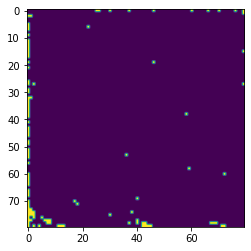

In [ ]:
plt.imshow(arg_outputs.detach())

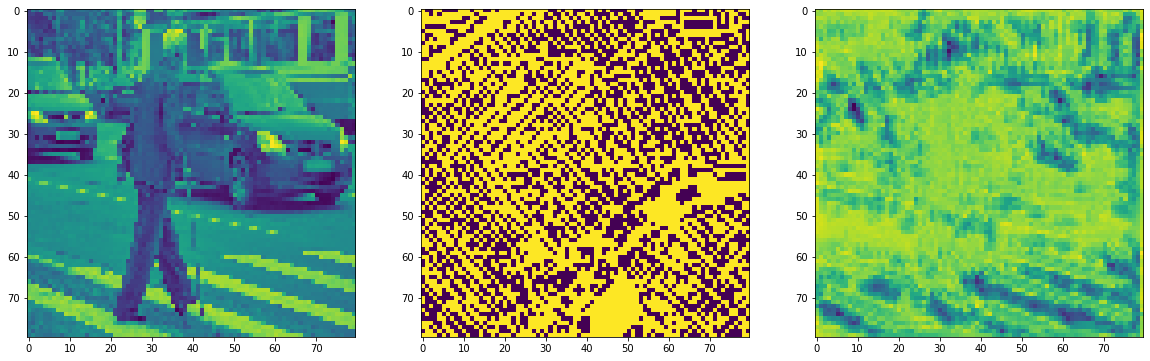

In [ ]:
arg_outputs = outputs[0][0][24] > 0
arg_outputs = torch.tensor(arg_outputs, dtype=torch.float)

# print(outputs[0])
f, axis = plt.subplots(1, 3)
f.set_figheight(10)
f.set_figwidth(20)

axis[0].imshow(resized_img[0][1].detach());
axis[1].imshow(true_mask[0][0].detach())
# axis[2].imshow(arg_outputs.detach())
axis[2].imshow(outputs[0][0][7].detach())

# PytorchLightning classes

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

BATCH_SIZE = 2
LEARNING_RATE = 1e-3
EPOCHS = 30

date = datetime.datetime.today()
date = date.date()

In [ ]:
# DATA_DIR = 'mas_data/mas-roofs'
DATA_DIR = 'data'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
class AutoPIDNet(pl.LightningModule):

    def __init__(self, cfg, learning_rate: float = 1e-4, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(AutoPIDNet, self).__init__()
        self.augment = augment
        self.save_hyperparameters("learning_rate")
        self.cfg = cfg
        self.model = get_seg_model(cfg=self.cfg, imgnet_pretrained=True)
        
        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)
        
        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)
        
        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)
            
        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)
        
        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)           

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)
    

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)
        
        return layer


    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)
        
        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_
        
        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))
        
        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d
            
        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment: 
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_   


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        train_loss = F.cross_entropy(y_hat[0], y, reduction="mean")
        print(train_loss, '-train')

        return train_loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        val_loss = F.cross_entropy(y_hat[0], y, reduction="mean")
        print(val_loss, '--valid')

        return val_loss


    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x for x in outputs]).mean()
        self.log('val_loss', avg_loss, prog_bar=True)
        return avg_loss 


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

        return optimizer

In [ ]:
class PIDNetDataset(torch.utils.data.Dataset):
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
    
    def __getitem__(self, i):
        if isinstance(i, slice):
            output = cl.defaultdict(list)
            for i in range(i.start, i.stop):
                for key, value in self[i].items():
                    output[key].append(value)
            for key, value in output.items():
                output[key] = torch.stack(value)
            return output

        
        image = Image.open(self.image_paths[i]).convert('RGB')
        mask = Image.open(self.mask_paths[i]).convert('RGB')
        
        image = self.feature_extractor(images=image, return_tensors="pt")
        mask = self.feature_extractor(images=mask, return_tensors="pt")

        image = image["pixel_values"][0]
        mask["pixel_values"] = mask["pixel_values"][0]

        #reshaping mask
        transform = T.Resize((80,80))
        reshaped_mask = transform(mask['pixel_values'])

        true_mask = reshaped_mask < -1.0
        true_mask = torch.tensor(true_mask, dtype=torch.long) #long)
        true_mask[true_mask == 0] = 11
        true_mask[true_mask == 1] = 6
        return {
            "image": image, 
            "mask": true_mask[0]
            }
        
    def __len__(self):
        return len(self.image_paths)

In [ ]:
class PIDNetDataModule(pl.LightningDataModule):
    def __init__(self, 
                 batch_size: int = 2):
        
        super().__init__()
        self.batch_size = batch_size

    def insert_data(self, train_dataset, val_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, drop_last=True)

# Train model

In [ ]:
train_dataset = PIDNetDataset(
    x_train_dir, y_train_dir,
)

valid_dataset = PIDNetDataset(
    x_valid_dir, y_valid_dir
)
data_loaders = PIDNetDataModule(batch_size=BATCH_SIZE)
data_loaders.insert_data(train_dataset, valid_dataset)

Find optimal learning rate

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(11.0523) --valid
tensor(9.7773) --valid


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tensor(4.3171, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.3364, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.3938, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.0416, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.4091, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.0612, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.2595, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.1437, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.3393, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.2934, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.0168, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.3150, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.1999, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.0609, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.2975, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.1810, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.4890, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.1640, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.4984, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.311

Restoring states from the checkpoint path at /content/.lr_find_2cd353b0-7015-448f-8915-6357b82e9ab8.ckpt


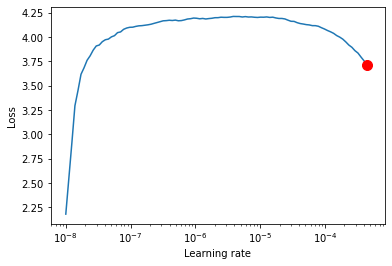

In [ ]:
# data_transforms = transforms.Compose([transforms.ToTensor()])
cfg = Config(model_name='pidnet_s', num_classes=30, path_to_pretrained_model='PIDNet_S_ImageNet.pth.tar')

model = AutoPIDNet(cfg=cfg, learning_rate=LEARNING_RATE)

trainer = pl.Trainer(
    # gpus=-1,
    auto_lr_find=False,
    val_check_interval=0.5,
    log_every_n_steps=1,
    max_epochs=EPOCHS,
)

lr_finder = trainer.tuner.lr_find(model=model,
                                  datamodule=data_loaders,
                                  num_training=100,
                                  max_lr=5e-4)
fig = lr_finder.plot(suggest=True)
fig.show()

Training model

In [ ]:
# model = AutoPIDNet(cfg=cfg, learning_rate=LEARNING_RATE)

# trainer = pl.Trainer(
#     # gpus=-1,
#     auto_lr_find=False,
#     val_check_interval=0.5,
#     log_every_n_steps=1,
#     max_epochs=EPOCHS,
# )
model.hparams.learning_rate = lr_finder.suggestion()

trainer.fit(model, data_loaders)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name         | Type        | Params
----------------------------------------------
0  | model        | PIDNet      | 7.7 M 
1  | conv1        | Sequential  | 39.0 K
2  | relu         | ReLU        | 0     
3  | layer1       | Sequential  | 147 K 
4  | layer2       | Sequential  | 525 K 
5  | layer3       | Sequential  | 3.3 M 
6  | layer4       | Sequential  | 13.1 M
7  | layer5       | Sequential  | 7.1 M 
8  | compression3 | Sequential  | 33.0 K
9  | compression4 | Sequential  | 65.8 K
10 | pag3         | PagFM       | 16.6 K
11 | pag4         | PagFM       | 16.6 K
12 | layer3_      | Sequential  | 590 K 
13 | layer4_      | Sequential  | 590 K 
14 | layer5_      | Sequential  | 230 K 
15 | layer3_d     | BasicBlock  | 119 K 
16 | layer4_d     | Sequential  | 58.1 K
17 | diff3        | Sequential  | 147 K 
18 | diff4        | Sequen

Sanity Checking: 0it [00:00, ?it/s]

tensor(14.8051) --valid
tensor(14.4864) --valid


Training: 0it [00:00, ?it/s]

tensor(5.3045, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.7249, grad_fn=<NllLoss2DBackward0>) -train
tensor(3.9969, grad_fn=<NllLoss2DBackward0>) -train
tensor(3.7213, grad_fn=<NllLoss2DBackward0>) -train
tensor(4.0083, grad_fn=<NllLoss2DBackward0>) -train
tensor(2.8631, grad_fn=<NllLoss2DBackward0>) -train
tensor(3.0299, grad_fn=<NllLoss2DBackward0>) -train
tensor(2.5595, grad_fn=<NllLoss2DBackward0>) -train
tensor(2.0950, grad_fn=<NllLoss2DBackward0>) -train
tensor(3.7726, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.9600, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.7656, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.9771, grad_fn=<NllLoss2DBackward0>) -train
tensor(2.0750, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.5262, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.3354, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.5871, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.3522, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.9790, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.616

Validation: 0it [00:00, ?it/s]

tensor(1.5923) --valid
tensor(1.5469) --valid
tensor(0.7146, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8488, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.9155, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5899, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8518, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.1996, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.0022, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.9404, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6082, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5544, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7436, grad_fn=<NllLoss2DBackward0>) -train
tensor(1.0285, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7553, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.9060, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5376, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8092, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7998, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5981, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5105, gra

Validation: 0it [00:00, ?it/s]

tensor(0.5628) --valid
tensor(0.6721) --valid
tensor(0.8382, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5139, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4530, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6020, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6996, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6218, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4698, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6072, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4913, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6651, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8777, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8197, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4196, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7035, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5884, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6801, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4516, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5185, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4742, gra

Validation: 0it [00:00, ?it/s]

tensor(0.4637) --valid
tensor(0.5479) --valid
tensor(0.6876, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5766, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6233, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6203, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6716, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4896, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6082, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6328, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6154, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4577, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5465, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4638, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5523, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.9803, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5468, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6639, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7586, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4374, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5357, gra

Validation: 0it [00:00, ?it/s]

tensor(0.4412) --valid
tensor(0.5207) --valid
tensor(0.5146, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4778, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5898, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4745, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6609, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4478, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5209, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.9039, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5149, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3622, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5099, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5352, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5086, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3691, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3316, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5663, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5477, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3282, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6092, gra

Validation: 0it [00:00, ?it/s]

tensor(0.4242) --valid
tensor(0.5050) --valid
tensor(0.4519, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5118, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8658, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5007, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4132, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4384, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6116, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4910, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4112, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3671, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3380, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5935, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4637, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3762, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.9874, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3491, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3506, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3025, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4450, gra

Validation: 0it [00:00, ?it/s]

tensor(0.3334) --valid
tensor(0.4229) --valid
tensor(0.6674, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5900, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7208, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4082, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4856, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5612, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5238, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3743, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5075, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4140, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4256, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3544, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4393, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3479, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5004, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4241, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6492, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3167, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4301, gra

Validation: 0it [00:00, ?it/s]

tensor(0.3274) --valid
tensor(0.4158) --valid
tensor(0.5674, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8107, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4187, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.4173, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5556, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5770, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5679, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7316, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6280, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7417, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6266, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7374, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.6941, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5886, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5330, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.3845, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.7574, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.8252, grad_fn=<NllLoss2DBackward0>) -train
tensor(0.5139, gra

In [ ]:
model_filename = f"PIDNet_model_{date}.ckpt"
trainer.save_checkpoint(model_filename)

In [ ]:
# !cp segmodel_2022-07-26_1.ckpt drive/MyDrive/'Дипломный проект'/'trained models'/segmodel_2022-07-26_1.ckpt
os.system(f'cp PIDNet_model_{date}.ckpt "drive/MyDrive/Дипломный проект/trained models/segmodel_{date}.ckpt"')

0

# Test model

In [ ]:
# model_ckpt_path = f'drive/MyDrive/Дипломный проект/trained models/segmodel_{date}.ckpt'

model = AutoPIDNet.load_from_checkpoint(model_filename, cfg=cfg)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
print('Loaded PIDNet model from this run.')

Loaded SegFormer model from this run.


In [ ]:
test_dataset = PIDNetDataset(
    x_test_dir, y_test_dir
)

In [ ]:
image = Image.open('mas_data/mas-roofs/test/22828930_15.png').convert('RGB')
mask = Image.open('mas_data/mas-roofs/test_labels/22828930_15.png').convert('RGB')

# image = Image.open('data/val/Снимок экрана 2022-05-13 в 13.27.19.png').convert('RGB')
# mask = Image.open('data/val_labels/Снимок экрана 2022-05-13 в 13.27.19.png').convert('RGB')

image = feature_extractor(images=image, return_tensors="pt")
mask = feature_extractor(images=mask, return_tensors="pt")

# image["pixel_values"] = imagev[0]#["pixel_values"][0]
# mask["pixel_values"] = maskv[0]#["pixel_values"][0]

#reshaping mask
transform = T.Resize((80,80))
reshaped_mask = transform(mask['pixel_values'])
# reshaped_mask = reshaped_mask[0][0]

true_mask = reshaped_mask > -2.117
true_mask = torch.tensor(true_mask, dtype=torch.long)
# print(true_mask[0], true_mask[1], true_mask[2])

In [ ]:
img_batch = test_dataset[0:3]["image"]
mask_batch = test_dataset[0:3]["mask"]

In [ ]:
# transform80 = T.Resize((80, 80))
# res_image = transform80(img_batch)
outputs = model(img_batch)
# pred_seg = transform_logits(logits)

In [ ]:
arg_outputs = outputs[0]
# print(outputs[0][0][6].min())
arg_outputs = arg_outputs > 4
arg_outputs = torch.tensor(arg_outputs, dtype=torch.long)

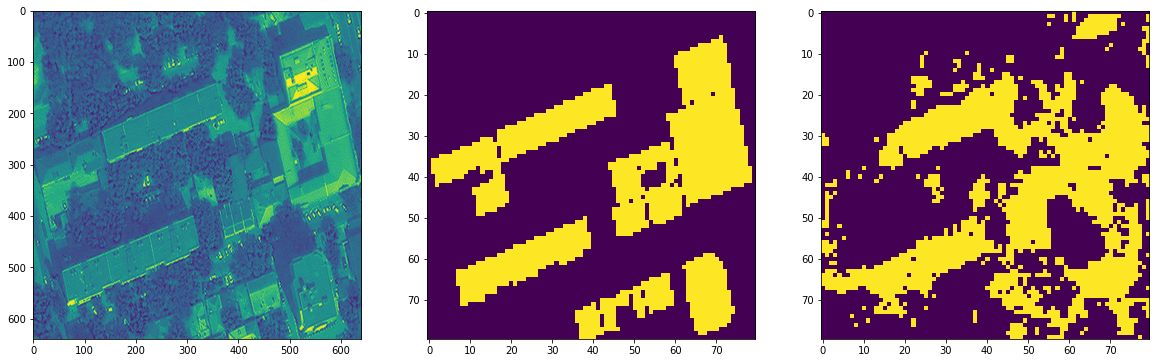

In [ ]:
# loss = F.cross_entropy(logits[0][0], true_mask[0][0], reduction="mean")
# print(f'loss == {loss}')

f, axis = plt.subplots(1, 3)
f.set_figheight(10)
f.set_figwidth(20)
axis[0].imshow(img_batch[0][0].detach());
axis[1].imshow(mask_batch[0].detach())
# axis[2].imshow(outputs[0][0][6].detach())
axis[2].imshow(arg_outputs[0][6].detach())

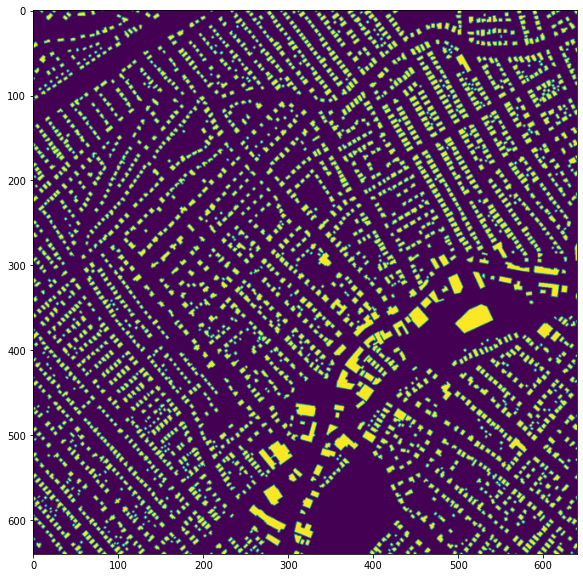

In [ ]:
f, axis = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(20)
plt.imshow(mask['pixel_values'][0][0])